# kinnd

## Kind  Introduction to Neural Network Decipherement

In [145]:
%matplotlib inline
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np


In [146]:
def mult(parameter, inputs):
    return parameter.dot(inputs[0]).flatten()

def linear(inputs):
    return inputs[0]

def squared_loss(pred, gold):
    return np.abs(pred - gold)**2


/Users/anders/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


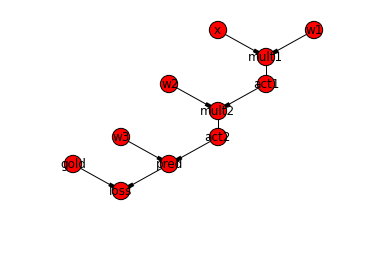

In [147]:
G = nx.DiGraph()

# Input, parameters and gold
G.add_nodes_from(['x', 'w1', 'w2', 'w3', 'gold'])

# Layer 1
G.add_node('mult1', op=mult)
G.add_node('act1', op=linear)

G.add_edge('x', 'mult1')
G.add_edge('w1', 'mult1', role='parameter')
G.add_edge('mult1', 'act1')

# Layer 2
G.add_node('mult2', op=mult)
G.add_node('act2', op=linear)

G.add_edge('act1', 'mult2')
G.add_edge('w2', 'mult2', role='parameter')
G.add_edge('mult2', 'act2')

# Output layer
G.add_node('pred', op=mult)
G.add_edge('w3', 'pred', role='parameter')
G.add_edge('act2', 'pred')

# Loss node
G.add_node('loss', op=squared_loss)
G.add_edge('pred', 'loss', role='pred')
G.add_edge('gold', 'loss', role='gold')

fig, ax = plt.subplots()
nx.draw_graphviz(G, prog='dot', ax=ax, with_labels=True)


Set some initial values

In [148]:
G.node['x']['value'] = np.array([1, 0, 1])
G.node['w1']['value'] = np.random.random((4, 3))
G.node['w2']['value'] = np.random.random((4, 4))
G.node['w3']['value'] = np.random.random((1, 4))
G.node['gold']['value'] = 5

In [150]:
def call_op(n):
    n_attr = G.node[n]
    arg_dict = {}
    inputs = []
    
    for u, _, edge_attr in G.in_edges(n, data=True):
        u_attr = G.node[u]
        arg_name = edge_attr.get('role')
        if arg_name:
            arg_dict[arg_name] = G.node[u]['value']
        else:
            inputs.append(G.node[u]['value'])
            
    if inputs:
        arg_dict['inputs'] = inputs

    print("Calling op ", n_attr['op'].__name__, "for", n, "with args")
    for arg_name in arg_dict.keys():
        print(arg_name, end=" ")
        if isinstance(arg_dict[arg_name], list):
            print([np.array(arg).shape for arg in arg_dict[arg_name]])
        else:
            print(np.array(arg_dict[arg_name]).shape)
    
    return n_attr['op'](**arg_dict)


In [151]:
w1 = G.node['w1']['value']
x = G.node['x']['value']


In [152]:
for n in nx.topological_sort(G):
    try:
        n_attr = G.node[n]
        if 'op' in n_attr:
            n_attr['value'] = call_op(n)
    except Exception as e:
        print("Error processing node", n)
        raise e
        

Calling op  mult for mult1 with args
inputs [(3,)]
parameter (4, 3)
Calling op  linear for act1 with args
inputs [(4,)]
Calling op  mult for mult2 with args
inputs [(4,)]
parameter (4, 4)
Calling op  linear for act2 with args
inputs [(4,)]
Calling op  mult for pred with args
inputs [(4,)]
parameter (1, 4)
Calling op  squared_loss for loss with args
pred (1,)
gold ()


In [157]:
G.node['loss']

{'op': <function __main__.squared_loss>, 'value': array([ 0.00733688])}

In [164]:
G.successors('w1')

['mult1']

In [163]:
for n in nx.topological_sort(G, reverse=True)[1:]:
    
    
    G.successors(n)
    print(n, G.children(n))

AttributeError: 'DiGraph' object has no attribute 'children'

/Users/anders/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


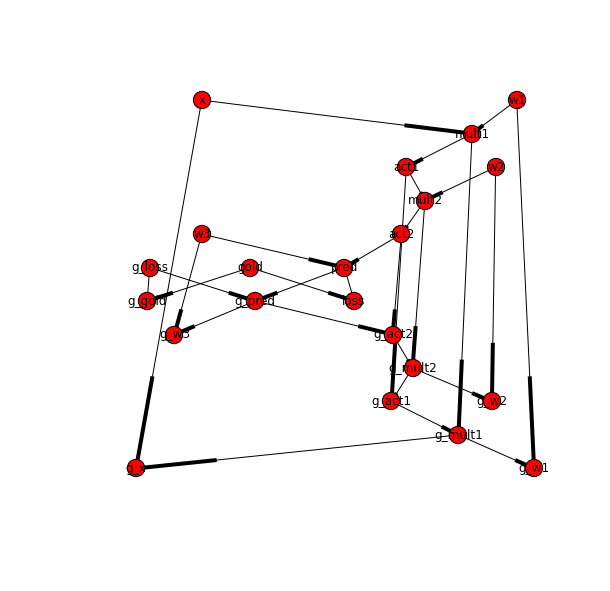

In [167]:
def add_backward(G):
    G_grad = G.copy()

    for n in nx.topological_sort(G, reverse=True)[1:]:
        # Add a corresponding gradient node
        grad_name = "g_" + n
        G_grad.add_node(grad_name)
        G_grad.add_edge(n, grad_name, role='activation')
        
        # Sum cached gradients
        for u in G.successors(n):
            cached_grad_name = "g_" + u
            G_grad.add_edge(cached_grad_name, grad_name)
        
    return G_grad


G_back = add_backward(G)
fig, ax = plt.subplots(figsize=(10,10))

nx.draw_graphviz(G_back, ax=ax, with_labels=True, prog='dot')

In [166]:
nx.topological_sort(G_back)

['w1',
 'w2',
 'w3',
 'g_loss',
 'gold',
 'g_gold',
 'x',
 'mult1',
 'act1',
 'mult2',
 'act2',
 'pred',
 'loss',
 'g_pred',
 'g_act2',
 'g_w3',
 'g_mult2',
 'g_w2',
 'g_act1',
 'g_mult1',
 'g_w1',
 'g_x']